In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, max_len):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        tokens = text.split()[:self.max_len]
        input_ids = [hash(token) % self.max_len for token in tokens]
        padding_length = self.max_len - len(input_ids)
        input_ids = input_ids + [0] * padding_length
        attention_mask = [1] * len(tokens) + [0] * padding_length
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels':torch.tensor(label, dtype=torch.float)
        }

In [3]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_classes, vocab_size, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.drop = nn.Dropout(p=dropout)
        self.out = nn.Linear(hidden_dim * 2, n_classes)
    
    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        pooled_output = torch.mean(lstm_out, dim=1)
        output = self.drop(pooled_output)
        return self.out(output)


In [4]:
df = pd.read_csv("/root/autodl-tmp/remotefolder/cleaned_tweet_80k.csv")
# df = pd.read_csv("/Users/jianhongxu/python_project/twitter_dataset/cleaned_tweet_80k.csv")
texts = df['tweet'].astype(str).values
labels = df['class'].values

In [5]:
ohe = OneHotEncoder(sparse_output=False)
labels = ohe.fit_transform(labels.reshape(-1,1))

In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

print(f'Training text length: {train_texts.shape[0]}')
print(f'Training label length: {train_labels.shape[0]}')
print(f'Test text length: {test_texts.shape[0]}')
print(f'Test label length: {test_labels.shape[0]}')

Training text length: 64000
Training label length: 64000
Test text length: 16000
Test label length: 16000


In [7]:
MAX_LEN = 128
VOCAB_SIZE = 30000 # Set an arbitrary vocabulary size for embedding


In [8]:
train_dataset = CustomDataset(train_texts, train_labels, MAX_LEN)
test_dataset = CustomDataset(test_texts, train_labels, MAX_LEN)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(embedding_dim=128, hidden_dim=256, n_classes=4, vocab_size=VOCAB_SIZE)
model = model.to(device)

In [11]:
optimizer = optim.Adam(model.parameters(), lr= 1e-6)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [12]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()
    total_loss = 0
    correct_predictions = 0
    total_examples = 0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids)

        loss = loss_fn(outputs,labels)
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).cpu()
        total_examples += labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}','accuracy':f'{correct_predictions.double() / total_examples:.4f}'})

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions.double() / total_examples
    return avg_loss, avg_accuracy

In [15]:
def eval_model(model, data_loader, device):
    model = model.eval()
    total_loss = 0
    correct_predictions = 0
    total_examples = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).cpu()
            total_examples += labels.size(0)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(torch.argmax(labels, dim=1).cpu().detach().numpy())
    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions.double() / total_examples
    return  true_labels, predictions, avg_accuracy, avg_loss
        

In [20]:
EPOCHS = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch +1}/{EPOCHS}')
    train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    scheduler.step(train_loss)

    _, _, val_accuracy, val_loss = eval_model(model, test_loader, device)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/20


Training Loss: 1.3872, Training Accuracy: 0.2514
Validation Loss: 1.3864, Validation Accuracy: 0.2482
Epoch 2/20


Training Loss: 1.3871, Training Accuracy: 0.2527
Validation Loss: 1.3864, Validation Accuracy: 0.2456
Epoch 3/20


Training Loss: 1.3870, Training Accuracy: 0.2532
Validation Loss: 1.3864, Validation Accuracy: 0.2442
Epoch 4/20


Training Loss: 1.3870, Training Accuracy: 0.2539
Validation Loss: 1.3864, Validation Accuracy: 0.2479
Epoch 5/20


Training Loss: 1.3872, Training Accuracy: 0.2517
Validation Loss: 1.3864, Validation Accuracy: 0.2461
Epoch 6/20


Training Loss: 1.3872, Training Accuracy: 0.2516
Validation Loss: 1.3864, Validation Accuracy: 0.2497
Epoch 7/20


Training Loss: 1.3867, Training Accuracy: 0.2560
Validation Loss: 1.3864, Validation Accuracy: 0.2490
Epoch 8/20


Training Loss: 1.3869, Training Accuracy: 0.2530
Validation Loss: 1.3864, Validation Accuracy: 0.2498
Epoch 9/20


Training Loss: 1.3866, Training Accuracy: 0.2560
Validation Loss: 1.3864, Validation Accuracy: 0.2499
Epoch 10/20


Training Loss: 1.3872, Training Accuracy: 0.2508
Validation Loss: 1.3864, Validation Accuracy: 0.2497
Epoch 11/20


Training Loss: 1.3868, Training Accuracy: 0.2521
Validation Loss: 1.3864, Validation Accuracy: 0.2507
Epoch 12/20


Training Loss: 1.3871, Training Accuracy: 0.2540
Validation Loss: 1.3864, Validation Accuracy: 0.2510
Epoch 13/20


Training Loss: 1.3872, Training Accuracy: 0.2505
Validation Loss: 1.3864, Validation Accuracy: 0.2510
Epoch 14/20


Training Loss: 1.3869, Training Accuracy: 0.2550
Validation Loss: 1.3864, Validation Accuracy: 0.2508
Epoch 15/20


Training Loss: 1.3873, Training Accuracy: 0.2534
Validation Loss: 1.3864, Validation Accuracy: 0.2505
Epoch 16/20


Training Loss: 1.3873, Training Accuracy: 0.2517
Validation Loss: 1.3864, Validation Accuracy: 0.2506
Epoch 17/20


Training Loss: 1.3868, Training Accuracy: 0.2545
Validation Loss: 1.3864, Validation Accuracy: 0.2510
Epoch 18/20


Training Loss: 1.3870, Training Accuracy: 0.2547
Validation Loss: 1.3864, Validation Accuracy: 0.2519
Epoch 19/20


Training Loss: 1.3869, Training Accuracy: 0.2538
Validation Loss: 1.3864, Validation Accuracy: 0.2521
Epoch 20/20


Training Loss: 1.3867, Training Accuracy: 0.2523
Validation Loss: 1.3864, Validation Accuracy: 0.2510


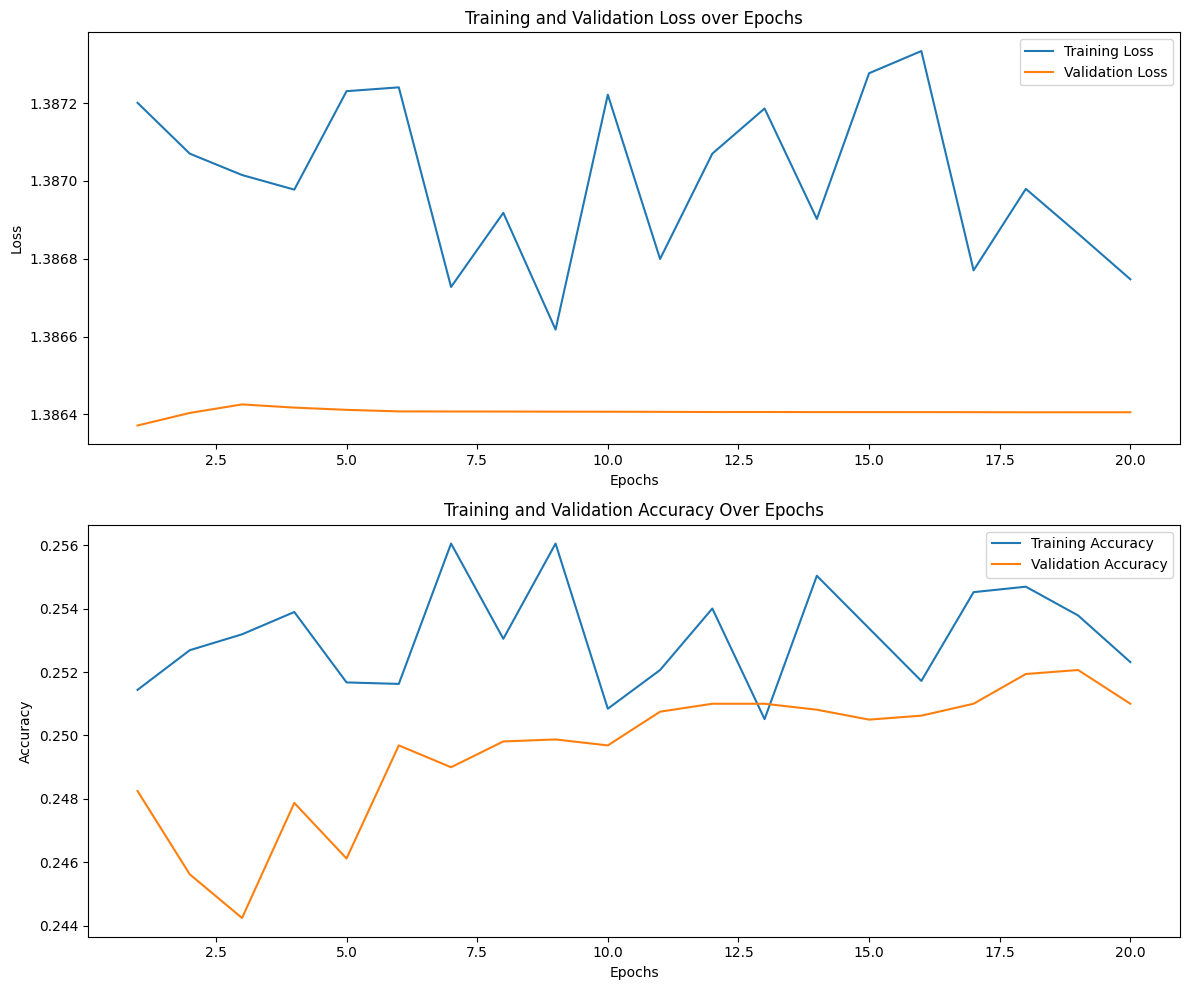

In [21]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.plot(range(1,EPOCHS +1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label ='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()


plt.subplot(2,1,2)
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.2510


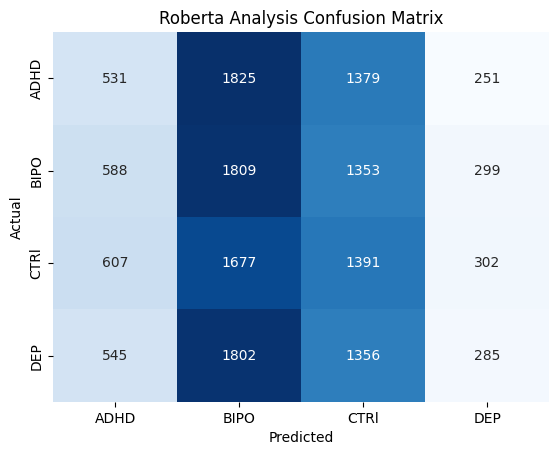

              precision    recall  f1-score   support

        ADHD       0.23      0.13      0.17      3986
     BIPOLAR       0.25      0.45      0.32      4049
     CONTROL       0.25      0.35      0.29      3977
  DEPRESSION       0.25      0.07      0.11      3988

    accuracy                           0.25     16000
   macro avg       0.25      0.25      0.22     16000
weighted avg       0.25      0.25      0.23     16000



In [22]:
# Evaluation
y_true, y_pred, test_accuracy, _ = eval_model(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')
conf_matrix = confusion_matrix(y_true, y_pred)
labels=["ADHD", "BIPO", "CTRl", "DEP"]
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', cbar=False)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Roberta Analysis Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=["ADHD", "BIPOLAR", "CONTROL", "DEPRESSION"]))